## Part I. Review the online programming

### （1）defaultdict

In [2]:
from collections import defaultdict
some_default_dict = defaultdict(int)

some_default_dict[0] = 3
some_default_dict[2] ## 因为上面是int，所以这里会输出来0，相当于没有定义的值会默认为0

0

### （2）切割钢管：引入动态规划

In [187]:
## 钢管对应的长度以及价格
original_price = [1, 5, 8, 9, 10, 17, 17, 20, 24, 30, 39] # 对应长度为[1,2,3,4,5,6,7,8,9,10,11]的钢管的价格
from collections import defaultdict
price = defaultdict(int)
for i, p in enumerate(original_price):
	price[i + 1] = p
price[11]

39

### （3）引入装饰器

#### a. python是面向函数的编程语言，函数是可操作的对象

In [4]:
## 面向函数的编程语言，即函数也可以作为参数传入函数
def example(f, arg):
	return f(arg)

def add_ten(num):
	return num + 10

def mul_ten(num):
	return num * 10

operations = [add_ten, mul_ten]
for f in operations:
	print(example(f, 100))

110
1000


#### b. 输出函数被调用的情况

##### 在没有使用装饰器时，输出函数被调用的情况

In [43]:
called_time = defaultdict(int) # 初始化值：0
def get_call_times(f): # 输出函数被调用一次
	result = f()
	print('function: {} called once! '.format(f.__name__)) # f.__name__可以获得函数的名字
	called_time[f.__name__] += 1
	return result

def some_function_1(): print('I am function 1')

get_call_times(some_function_1)

called_time

I am function 1
function: some_function_1 called once! 


defaultdict(int, {'some_function_1': 1})

In [46]:
call_time_with_arg = defaultdict(int)

def r(n):
	fname = r.__name__
	call_time_with_arg[(fname, n)] += 1
	return max(
		[price[n]] + [r(i) + r(n - i) for i in range(1, n)]
	)

print(r(6))
print(call_time_with_arg)

17
defaultdict(<class 'int'>, {('r', 6): 1, ('r', 1): 162, ('r', 5): 2, ('r', 4): 6, ('r', 3): 18, ('r', 2): 54})


In [47]:
call_time_with_arg

defaultdict(int,
            {('r', 6): 1,
             ('r', 1): 162,
             ('r', 5): 2,
             ('r', 4): 6,
             ('r', 3): 18,
             ('r', 2): 54})

In [50]:
from collections import Counter
Counter(call_time_with_arg).most_common()

[(('r', 1), 162),
 (('r', 2), 54),
 (('r', 3), 18),
 (('r', 4), 6),
 (('r', 5), 2),
 (('r', 6), 1)]

##### 使用装饰器时，输出函数被调用的情况 （no @wraps)

In [125]:
from functools import wraps

called_time_with_arg = defaultdict(int)

def get_call_time_1(f): # 没有添加 @wraps 的 get_call_time
	"""@param f is a function"""
	def wrap(n):
		"""Haha I am wrap"""
		print('I can count')
		result = f(n)
		called_time_with_arg[(f.__name__, n)] += 1
		return result
	return wrap

def add_ten(n):
	return n + 10

add_ten_with_call_time = get_call_time_1(add_ten)
add_ten_with_call_time(6)

I can count


16

In [126]:
called_time_with_arg

defaultdict(int, {('add_ten', 6): 1})

In [127]:
@get_call_time_1 # 相当于执行了 add_twenty = get_call_time(add_twenty)
def add_twenty(n):
	return n + 20

add_twenty(23)
called_time_with_arg

I can count


defaultdict(int, {('add_ten', 6): 1, ('add_twenty', 23): 1})

In [139]:
## 使用了装饰器的函数r(n) ##
call_time_with_arg = defaultdict(int)

def r(n):
	"""
	Args: n is the iron length
	Return: the max revenue
	"""
	return max(
		[price[n]] + [r(i) + r(n - i) for i in range(1, n)]
	)

help(r)
print("\n")
print("------@*@*@* 分界线 @*@*@*-------")
print("\n")
## 使用装饰器返回的函数
r_with_call_time = get_call_time_1(r)
help(r_with_call_time)

Help on function r in module __main__:

r(n)
    Args: n is the iron length
    Return: the max revenue



------@*@*@* 分界线 @*@*@*-------


Help on function wrap in module __main__:

wrap(n)
    Haha I am wrap



##### 使用装饰器时，输出函数被调用的情况 （with @wraps)

In [149]:
## 添加了 @wraps 的 get_call_time，从而就不会更改原来函数的名字以及docstring信息 ##
def get_call_time_2(f):
	"""@param f is a function"""
	@wraps(f)
	def wrap(n):
		"""Haha I am wrap"""
		# print('I can count')
		result = f(n)
		call_time_with_arg[(f.__name__, n)] += 1
		return result
	return wrap

r = get_call_time_2(r)
help(r)

Help on function r in module __main__:

r(n)
    Args: n is the iron length
    Return: the max revenue



In [154]:
@get_call_time_2
def r(n):
	"""
	Args: n is the iron length
	Return: the max revenue
	"""
	return max(
		[price[n]] + [r(i) + r(n - i) for i in range(1, n)]
	)

call_time_with_arg = defaultdict(int)
print(r(5))
call_time_with_arg

13


defaultdict(int,
            {('r', 1): 54,
             ('r', 2): 18,
             ('r', 3): 6,
             ('r', 4): 2,
             ('r', 5): 1})

###  （4）定义装饰器memo，用于保存已经计算过的数据 (Get the max splitting by enumerate)

In [188]:
## 定义装饰器memo用于保存已经求算过的数据 ##
def memo(f): 
	memo.already_computed = {}
	@wraps(f)
	def _wrap(arg):
		result = None
		
		if arg in memo.already_computed: 
			result = memo.already_computed[arg]
		else:
			result = f(arg)
			memo.already_computed[arg] = result
		
		return result
	
	return _wrap


called_time_with_arg = defaultdict(int)
solution = {}

## 使用memo装饰r
@memo
def r(n):
	"""
	Args: n is the iron length
	Return: the max revenue 
	"""
	max_price, max_split = max(
		[(price[n], 0)] + [(r(i) + r(n-i), i) for i in range(1, n)], key=lambda x: x[0]
	)

	solution[n] = (n - max_split, max_split)
	
	return max_price

In [194]:
## 这里计算速度就提升了很多 ##
print(r(23))
print(solution)
memo.already_computed

79
{1: (1, 0), 2: (2, 0), 3: (3, 0), 4: (2, 2), 5: (3, 2), 6: (6, 0), 7: (6, 1), 8: (6, 2), 9: (6, 3), 10: (10, 0), 11: (11, 0), 12: (11, 1), 13: (11, 2), 14: (11, 3), 15: (13, 2), 16: (14, 2), 17: (11, 6), 18: (17, 1), 19: (17, 2), 20: (17, 3), 21: (11, 10), 22: (11, 11), 23: (22, 1), 24: (22, 2), 25: (22, 3), 26: (24, 2), 27: (25, 2), 28: (22, 6), 29: (28, 1), 30: (28, 2), 31: (28, 3), 32: (22, 10), 33: (22, 11), 34: (33, 1), 35: (33, 2), 36: (33, 3), 37: (35, 2), 38: (36, 2), 39: (33, 6), 40: (39, 1), 41: (39, 2), 42: (39, 3), 43: (33, 10), 44: (33, 11), 45: (44, 1), 46: (44, 2), 47: (44, 3), 48: (46, 2), 49: (47, 2), 50: (44, 6), 51: (50, 1), 52: (50, 2), 53: (50, 3), 54: (44, 10), 55: (44, 11), 56: (55, 1), 57: (55, 2), 58: (55, 3), 59: (57, 2), 60: (58, 2), 61: (55, 6), 62: (61, 1), 63: (61, 2), 64: (61, 3), 65: (55, 10), 66: (55, 11), 67: (66, 1), 68: (66, 2), 69: (66, 3), 70: (68, 2), 71: (69, 2), 72: (66, 6), 73: (72, 1), 74: (72, 2), 75: (72, 3), 76: (66, 10), 77: (66, 11), 7

{1: 1,
 2: 5,
 3: 8,
 4: 10,
 5: 13,
 6: 17,
 7: 18,
 8: 22,
 9: 25,
 10: 30,
 11: 39,
 12: 40,
 13: 44,
 14: 47,
 15: 49,
 16: 52,
 17: 56,
 18: 57,
 19: 61,
 20: 64,
 21: 69,
 22: 78,
 23: 79,
 24: 83,
 25: 86,
 26: 88,
 27: 91,
 28: 95,
 29: 96,
 30: 100,
 31: 103,
 32: 108,
 33: 117,
 34: 118,
 35: 122,
 36: 125,
 37: 127,
 38: 130,
 39: 134,
 40: 135,
 41: 139,
 42: 142,
 43: 147,
 44: 156,
 45: 157,
 46: 161,
 47: 164,
 48: 166,
 49: 169,
 50: 173,
 51: 174,
 52: 178,
 53: 181,
 54: 186,
 55: 195,
 56: 196,
 57: 200,
 58: 203,
 59: 205,
 60: 208,
 61: 212,
 62: 213,
 63: 217,
 64: 220,
 65: 225,
 66: 234,
 67: 235,
 68: 239,
 69: 242,
 70: 244,
 71: 247,
 72: 251,
 73: 252,
 74: 256,
 75: 259,
 76: 264,
 77: 273,
 78: 274,
 79: 278,
 80: 281,
 81: 283,
 82: 286,
 83: 290,
 84: 291,
 85: 295,
 86: 298,
 87: 303,
 88: 312,
 89: 313}

### （5）给定某长度钢筋，输出最佳切割方案

In [190]:
## 通过此函数输出切割方案 ##
def parse_solution(n):
    left_split, right_split = solution[n]
    
    if right_split == 0: return [left_split]
    
    return parse_solution(left_split) + parse_solution(right_split)

In [191]:
print(r(56))
parse_solution(56)

196


[11, 11, 11, 11, 11, 1]

### （6）动态规划 (不断查表)

### （7）Gradient Descent to get optimal k and b

### 损失函数

### $$loss = \frac{1}{n}\sum{(y_i - \hat(y_i))^2}$$

### 对k求偏导

### $$\frac{\partial loss}{\partial k} = - \frac{2}{n}\sum{{x_i(y_i - \hat{y_i})}}$$

### 对b求偏导数

### $$\frac{\partial loss}{\partial b} = - \frac{2}{n}\sum{{(y_i - \hat{y_i})}}$$

In [232]:
def partial_k(x, y, y_hat):
	n = len(y)
	gradient = 0
	for x_i, y_i, y_hat_i in zip(list(x), list(y), list(y_hat)):
		gradient += (y_i - y_hat_i) * x_i
	return -2 / n * (gradient)

def partial_b(x, y, y_hat):
	n = len(y)
	gradient = 0
	for y_i, y_hat_i in zip(list(y), list(y_hat)):
		gradient += (y_i - y_hat_i)
	return -2 / n * (gradient)

In [233]:
def loss(y, y_hat): # to evaluate the performance 
	return sum((y_i - y_hat_i)**2 for y_i, y_hat_i in zip(list(y), list(y_hat))) / len(list(y))

def loss_new(y, y_hat):
	return sum(abs(y_i - y_hat_i) for y_i, y_hat_i in zip(list(y), list(y_hat))) / len(list(y))

def price(rm, k, b):
	"""f(x) = k * x + b"""
	return k * rm + b

%matplotlib inline
def draw_rm_and_price():
	plt.scatter(X[:, 5], y)

In [234]:
trying_times = 2000
X, y = data['data'], data['target']
min_loss = float('inf')
current_k = random.random() * 200 - 100
current_b = random.random() * 200 - 100
learning_rate = 0.001
updata_time = 0

for i in range(trying_times):
	price_by_random_k_and_b = [price(r, current_k, current_b) for r in X_rm]
	current_loss = loss(y, price_by_random_k_and_b)
	if current_loss < min_loss:
		min_loss = current_loss
		if i % 50:
			print('When time is {}, get best_k: {} best_b: {}, and the loss is {}'.format(i, current_k, current_b, min_loss))
	k_gradient = partial_k(X_rm, y, price_by_random_k_and_b)
	b_gradient = partial_b(X_rm, y, price_by_random_k_and_b)
	current_k = current_k + (-1 * k_gradient) * learning_rate # k与偏导方向相反
	current_b = current_b + (-1 * b_gradient) * learning_rate # b与偏导方向相反

When time is 1, get best_k: -44.89521449839375 best_b: 60.271983115228345, and the loss is 61216.81221961055
When time is 2, get best_k: -41.769940612694604 best_b: 60.76080477937439, and the loss is 51620.558982232295
When time is 3, get best_k: -38.90076604162585 best_b: 61.20936639272823, and the loss is 43532.765245346694
When time is 4, get best_k: -36.266702268543625 best_b: 61.62096745651005, and the loss is 36716.31226698585
When time is 5, get best_k: -33.84848088233155 best_b: 61.99863706263073, and the loss is 30971.35462792257
When time is 6, get best_k: -31.6284126068369 best_b: 62.34515605497913, and the loss is 26129.461139400653
When time is 7, get best_k: -29.59025788349319 best_b: 62.663077374489944, and the loss is 22048.67675708836
When time is 8, get best_k: -27.719108060292413 best_b: 62.9547447368396, and the loss is 18609.360725849878
When time is 9, get best_k: -26.001276317867795 best_b: 63.22230977941901, and the loss is 15710.678937557337
When time is 10, ge

When time is 443, get best_k: -6.597896463199282 best_b: 65.19896660787501, and the loss is 166.486984340988
When time is 444, get best_k: -6.59751892161457 best_b: 65.1965650213011, and the loss is 166.48107425632898
When time is 445, get best_k: -6.597141389108687 best_b: 65.19416349247868, and the loss is 166.47516445590915
When time is 446, get best_k: -6.596763865681414 best_b: 65.19176202140638, and the loss is 166.46925493971455
When time is 447, get best_k: -6.596386351332531 best_b: 65.1893606080828, and the loss is 166.46334570773138
When time is 448, get best_k: -6.596008846061822 best_b: 65.18695925250654, and the loss is 166.45743675994618
When time is 449, get best_k: -6.595631349869067 best_b: 65.18455795467622, and the loss is 166.4515280963451
When time is 451, get best_k: -6.5948763847165495 best_b: 65.17975553224787, and the loss is 166.43971162164087
When time is 452, get best_k: -6.59449891575635 best_b: 65.17735440764704, and the loss is 166.4338038105104
When tim

When time is 707, get best_k: -6.498540004545312 best_b: 64.56694844935323, and the loss is 164.93654831137974
When time is 708, get best_k: -6.498164852207852 best_b: 64.56456206106304, and the loss is 164.9307127931968
When time is 709, get best_k: -6.497789708891765 best_b: 64.56217573015887, and the loss is 164.9248775556663
When time is 710, get best_k: -6.497414574596834 best_b: 64.55978945663934, and the loss is 164.9190425987753
When time is 711, get best_k: -6.497039449322843 best_b: 64.55740324050306, and the loss is 164.91320792250986
When time is 712, get best_k: -6.496664333069574 best_b: 64.55501708174867, and the loss is 164.9073735268565
When time is 713, get best_k: -6.49628922583681 best_b: 64.55263098037477, and the loss is 164.90153941180222
When time is 714, get best_k: -6.495914127624334 best_b: 64.55024493638, and the loss is 164.8957055773323
When time is 715, get best_k: -6.4955390384319305 best_b: 64.54785894976297, and the loss is 164.8898720234349
When time 

When time is 1144, get best_k: -6.335454874312664 best_b: 63.52954469031936, and the loss is 162.41297804132697
When time is 1145, get best_k: -6.335083643720246 best_b: 63.527183248712184, and the loss is 162.40726389141602
When time is 1146, get best_k: -6.334712422054894 best_b: 63.52482186389113, and the loss is 162.40155001632044
When time is 1147, get best_k: -6.334341209316393 best_b: 63.522460535854826, and the loss is 162.39583641602687
When time is 1148, get best_k: -6.333970005504529 best_b: 63.52009926460192, and the loss is 162.3901230905229
When time is 1149, get best_k: -6.333598810619087 best_b: 63.51773805013103, and the loss is 162.38441003979452
When time is 1151, get best_k: -6.332856447626611 best_b: 63.513015791529874, and the loss is 162.3729847626134
When time is 1152, get best_k: -6.3324852795191475 best_b: 63.51065474739687, and the loss is 162.367272536134
When time is 1153, get best_k: -6.3321141203372475 best_b: 63.50829376004043, and the loss is 162.361560

When time is 1657, get best_k: -6.14618116672976 best_b: 62.32555230025488, and the loss is 159.51741626819054
When time is 1658, get best_k: -6.145814487645032 best_b: 62.32321981132524, and the loss is 159.51184137706343
When time is 1659, get best_k: -6.145447817377917 best_b: 62.32088737848549, and the loss is 159.50626675405468
When time is 1660, get best_k: -6.145081155928207 best_b: 62.318555001734275, and the loss is 159.50069239915106
When time is 1661, get best_k: -6.1447145032956865 best_b: 62.31622268107026, and the loss is 159.49511831233966
When time is 1662, get best_k: -6.1443478594801455 best_b: 62.31389041649208, and the loss is 159.4895444936078
When time is 1663, get best_k: -6.143981224481371 best_b: 62.311558207998395, and the loss is 159.48397094294256
When time is 1664, get best_k: -6.143614598299152 best_b: 62.30922605558786, and the loss is 159.4783976603308
When time is 1665, get best_k: -6.143247980933275 best_b: 62.306893959259114, and the loss is 159.47282

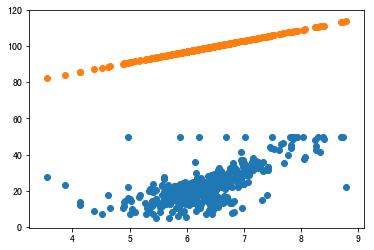

In [235]:
X_rm = X[:, 5]
k = 6
b = 61
price_by_random_k_and_b = [price(r, k, b) for r in X_rm]
draw_rm_and_price()
plt.scatter(X_rm, price_by_random_k_and_b)

## Part II. Change loss function from $loss = \frac{1}{n}\sum{(y_i - \hat(y_i))^2}$ to $loss = \frac{1}{n}\sum{|y_i - \hat{y_i}|}$, and using your mathmatical knowledge to get the right partial formula. Implement the gradient descent code.

### 损失函数

### $$loss = \frac{1}{n}\sum{|y_i - \hat{y_i}|}$$

### 对k求偏导

### $$\frac{\partial loss}{\partial k} = - \frac{1}{n}\sum{\frac{x_i|y_i - \hat{y_i}|}{y_i - \hat{y_i}}}$$

### 对b求偏导

### $$\frac{\partial loss}{\partial k} = - \frac{1}{n}\sum{\frac{|y_i - \hat{y_i}|}{y_i - \hat{y_i}}}$$

In [209]:
def partial_k(x, y, y_hat):
	"""
	对k求偏导数
	"""
	n = len(y)
	gradient = 0
	for x_i, y_i, y_hat_i in zip(list(x), list(y), list(y_hat)):
		gradient += abs(y_i - y_hat_i) * x_i / (y_i - y_hat_i)
	return -1 / n * (gradient)

def partial_b(x, y, y_hat):
	"""
	对b求偏导数
	"""
	n = len(y)
	gradient = 0
	for y_i, y_hat_i in zip(list(y), list(y_hat)):
		gradient += abs(y_i - y_hat_i) / (y_i - y_hat_i)
	return -1 / n * (gradient)

In [230]:
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt
import random
data = load_boston()
X, y = data['data'], data['target']
X_rm = X[:, 5]

##
trying_times = 2000
min_loss = float('inf')
current_k = random.random() * 200 - 100
current_b = random.random() * 200 - 100
learning_rate = 0.001
updata_time = 0
for i in range(trying_times):
	price_by_random_k_and_b = [price(r, current_k, current_b) for r in X_rm]
	current_loss = loss_new(y, price_by_random_k_and_b)

	if current_loss < min_loss:
		min_loss = current_loss
		if i % 50:
			print('When time is {}, get best_k: {} best_b: {}, and the loss is {}'.format(i, current_k, current_b, min_loss))

	k_gradient = partial_k(X_rm, y, price_by_random_k_and_b)
	b_gradient = partial_b(X_rm, y, price_by_random_k_and_b)

	current_k = current_k + (-1 * k_gradient) * learning_rate # k与偏导方向相反
	current_b = current_b + (-1 * b_gradient) * learning_rate # b与偏导方向相反

When time is 1, get best_k: 12.803260355705266 best_b: 50.48635430979261, and the loss is 108.41735828736489
When time is 2, get best_k: 12.796975721317914 best_b: 50.48535430979261, and the loss is 108.37686165798227
When time is 3, get best_k: 12.790691086930561 best_b: 50.484354309792614, and the loss is 108.33636502859964
When time is 4, get best_k: 12.784406452543209 best_b: 50.48335430979262, and the loss is 108.29586839921699
When time is 5, get best_k: 12.778121818155856 best_b: 50.48235430979262, and the loss is 108.25537176983418
When time is 6, get best_k: 12.771837183768504 best_b: 50.48135430979262, and the loss is 108.21487514045153
When time is 7, get best_k: 12.765552549381152 best_b: 50.480354309792624, and the loss is 108.17437851106901
When time is 8, get best_k: 12.7592679149938 best_b: 50.479354309792626, and the loss is 108.13388188168621
When time is 9, get best_k: 12.752983280606447 best_b: 50.47835430979263, and the loss is 108.09338525230355
When time is 10, g

When time is 230, get best_k: 11.36407908100157 best_b: 50.25735430979314, and the loss is 99.14363015872998
When time is 231, get best_k: 11.357794446614218 best_b: 50.256354309793146, and the loss is 99.10313352934735
When time is 232, get best_k: 11.351509812226865 best_b: 50.25535430979315, and the loss is 99.06263689996466
When time is 233, get best_k: 11.345225177839513 best_b: 50.25435430979315, and the loss is 99.02214027058189
When time is 234, get best_k: 11.33894054345216 best_b: 50.25335430979315, and the loss is 98.9816436411992
When time is 235, get best_k: 11.332655909064808 best_b: 50.252354309793155, and the loss is 98.9411470118166
When time is 236, get best_k: 11.326371274677456 best_b: 50.25135430979316, and the loss is 98.90065038243381
When time is 237, get best_k: 11.320086640290103 best_b: 50.25035430979316, and the loss is 98.86015375305118
When time is 238, get best_k: 11.313802005902751 best_b: 50.24935430979316, and the loss is 98.81965712366838
When time is

When time is 887, get best_k: 7.2350742885111625 best_b: 49.600354309794675, and the loss is 72.537344654306
When time is 888, get best_k: 7.228789654123811 best_b: 49.59935430979468, and the loss is 72.4968480249233
When time is 889, get best_k: 7.2225050197364595 best_b: 49.59835430979468, and the loss is 72.45635139554061
When time is 890, get best_k: 7.216220385349108 best_b: 49.59735430979468, and the loss is 72.41585476615785
When time is 891, get best_k: 7.2099357509617565 best_b: 49.596354309794684, and the loss is 72.3753581367753
When time is 892, get best_k: 7.203651116574405 best_b: 49.595354309794686, and the loss is 72.3348615073926
When time is 893, get best_k: 7.1973664821870535 best_b: 49.59435430979469, and the loss is 72.29436487800982
When time is 894, get best_k: 7.191081847799702 best_b: 49.59335430979469, and the loss is 72.25386824862717
When time is 895, get best_k: 7.184797213412351 best_b: 49.59235430979469, and the loss is 72.21337161924455
When time is 896,

When time is 1269, get best_k: 4.834343952542891 best_b: 49.218354309795565, and the loss is 57.067632230122065
When time is 1270, get best_k: 4.82805931815554 best_b: 49.21735430979557, and the loss is 57.0271356007394
When time is 1271, get best_k: 4.821774683768188 best_b: 49.21635430979557, and the loss is 56.9866389713567
When time is 1272, get best_k: 4.815490049380837 best_b: 49.21535430979557, and the loss is 56.94614234197399
When time is 1273, get best_k: 4.809205414993485 best_b: 49.214354309795574, and the loss is 56.90564571259134
When time is 1274, get best_k: 4.802920780606134 best_b: 49.21335430979558, and the loss is 56.86514908320863
When time is 1275, get best_k: 4.796636146218782 best_b: 49.21235430979558, and the loss is 56.82465245382598
When time is 1276, get best_k: 4.790351511831431 best_b: 49.21135430979558, and the loss is 56.78415582444332
When time is 1277, get best_k: 4.784066877444079 best_b: 49.210354309795584, and the loss is 56.7436591950606
When time 

When time is 1543, get best_k: 3.1123541304085185 best_b: 48.9443543097962, and the loss is 45.97155577926724
When time is 1544, get best_k: 3.1060694960211666 best_b: 48.943354309796206, and the loss is 45.931059149884575
When time is 1545, get best_k: 3.0997848616338146 best_b: 48.94235430979621, and the loss is 45.89056252050187
When time is 1546, get best_k: 3.0935002272464627 best_b: 48.94135430979621, and the loss is 45.85006589111919
When time is 1547, get best_k: 3.0872155928591107 best_b: 48.94035430979621, and the loss is 45.8095692617365
When time is 1548, get best_k: 3.080930958471759 best_b: 48.939354309796215, and the loss is 45.76907263235382
When time is 1549, get best_k: 3.074646324084407 best_b: 48.93835430979622, and the loss is 45.728576002971124
When time is 1551, get best_k: 3.062077055309703 best_b: 48.93635430979622, and the loss is 45.64758274420577
When time is 1552, get best_k: 3.055792420922351 best_b: 48.935354309796224, and the loss is 45.607086114823126
W

When time is 1755, get best_k: 1.7800116402899153 best_b: 48.7323543097967, and the loss is 37.386270350138425
When time is 1756, get best_k: 1.7737270059025636 best_b: 48.7313543097967, and the loss is 37.345773720755815
When time is 1757, get best_k: 1.7674423715152119 best_b: 48.7303543097967, and the loss is 37.30527709137312
When time is 1758, get best_k: 1.7611577371278602 best_b: 48.729354309796705, and the loss is 37.264780461990405
When time is 1759, get best_k: 1.7548731027405085 best_b: 48.72835430979671, and the loss is 37.22428383260774
When time is 1760, get best_k: 1.7485884683531567 best_b: 48.72735430979671, and the loss is 37.18378720322509
When time is 1761, get best_k: 1.742303833965805 best_b: 48.72635430979671, and the loss is 37.14329057384238
When time is 1762, get best_k: 1.7360191995784533 best_b: 48.725354309796714, and the loss is 37.10279394445968
When time is 1763, get best_k: 1.7297345651911016 best_b: 48.724354309796716, and the loss is 37.06229731507700

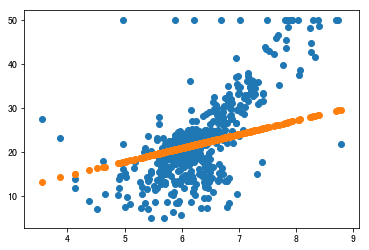

In [228]:
X_rm = X[:, 5]
k = 3.14
b = 2.09
price_by_random_k_and_b = [price(r, k, b) for r in X_rm]
draw_rm_and_price()
plt.scatter(X_rm, price_by_random_k_and_b)

### Part III. Finish the Solution Parse Part of Edit-Distance (step by step)

In [237]:
solution = {}

In [238]:
# @lru_cache(maxsize=2**10)
def edit_distance(string1, string2):
    
    if len(string1) == 0: return len(string2)
    if len(string2) == 0: return len(string1)
    
    tail_s1 = string1[-1]
    tail_s2 = string2[-1]
    
    candidates = [
        (edit_distance(string1[:-1], string2) + 1, 'DEL {}'.format(tail_s1)),  # string 1 delete tail
        (edit_distance(string1, string2[:-1]) + 1, 'ADD {}'.format(tail_s2)),  # string 1 add tail of string2
    ]
    
    if tail_s1 == tail_s2:
        both_forward = (edit_distance(string1[:-1], string2[:-1]) + 0, '')
    else:
        both_forward = (edit_distance(string1[:-1], string2[:-1]) + 1, 'SUB {} => {}'.format(tail_s1, tail_s2))

    candidates.append(both_forward)
    
    min_distance, operation = min(candidates, key=lambda x: x[0])
    
    solution[(string1, string2)] = operation 
    
    return min_distance

In [241]:
edit_distance('ABCDE', 'ABCCEF')

2

In [240]:
solution

{('A', 'A'): '',
 ('A', 'AB'): 'ADD B',
 ('A', 'ABC'): 'ADD C',
 ('A', 'ABCC'): 'ADD C',
 ('A', 'ABCCE'): 'ADD E',
 ('A', 'ABCCEF'): 'ADD F',
 ('AB', 'A'): 'DEL B',
 ('AB', 'AB'): '',
 ('AB', 'ABC'): 'ADD C',
 ('AB', 'ABCC'): 'ADD C',
 ('AB', 'ABCCE'): 'ADD E',
 ('AB', 'ABCCEF'): 'ADD F',
 ('ABC', 'A'): 'DEL C',
 ('ABC', 'AB'): 'DEL C',
 ('ABC', 'ABC'): '',
 ('ABC', 'ABCC'): 'ADD C',
 ('ABC', 'ABCCE'): 'ADD E',
 ('ABC', 'ABCCEF'): 'ADD F',
 ('ABCD', 'A'): 'DEL D',
 ('ABCD', 'AB'): 'DEL D',
 ('ABCD', 'ABC'): 'DEL D',
 ('ABCD', 'ABCC'): 'SUB D => C',
 ('ABCD', 'ABCCE'): 'ADD E',
 ('ABCD', 'ABCCEF'): 'ADD F',
 ('ABCDE', 'A'): 'DEL E',
 ('ABCDE', 'AB'): 'DEL E',
 ('ABCDE', 'ABC'): 'DEL E',
 ('ABCDE', 'ABCC'): 'DEL E',
 ('ABCDE', 'ABCCE'): '',
 ('ABCDE', 'ABCCEF'): 'ADD F'}

### Part IV. Choose 1 - 2 books to keep reading:

* SICP, Structure and Interpretation of Computer Programming.
* Introduction to Algorithms
* Artificial Intelligence A Modern Approach (3rd Edition)
* Code Complete 2
* Programming Pearls
* Deep Learning
* 黑客与画家
* 数学之美
* Fluent Python
* Hands on Tensorflow
* Conference: NIPS ICML ICLR ACL AAAI
* Most books you may find in our github: https://github.com/Computing-Intelligence/References

### Part V. Review machine learning

1. Why do we use Derivative / Gradient to fit a target function?¶
<br>Ans: 确保沿着损失函数减小的方向。

2. In the words 'Gradient Descent', what's the Gradient and what's the Descent?¶
<br>Ans: 梯度是偏导数的反方向。每一次下降的步长就是学习率。

3. What's the advantages of the 3rd gradient descent method compared to the previous methods?
<br>Ans: 确保损失函数是下降的，而且是找下降最快的方向。

4. Using the simple words to describe: What's the machine leanring.¶
<br>Ans: 机器学习算法是一类从数据中自动分析获得规律，并利用规律对未知数据进行预测的算法

### Part VI. Answer following questions:

1. Why do we need dynamic programming? What's the difference of dynamic programming and previous talked search problem?
<br>Ans: 
2. Why do we still need dynamic programming? Why not we train a machine learning to fit a function which could get the right answer based on inputs?
<br>Ans: 
3. Can you catch up at least 3 problems which could solved by Dynamic Programming?
<br>Ans: 
4. Can you catch up at least 3 problems wich could sloved by Edit Distance?
<br>Ans: 
5. Please summarize the three main features of Dynamic Programming, and make a concise explain for each feature.
<br>Ans: 
6. What's the disadvantages of Dynamic Programming? (You may need search by yourself in Internet)
<br>Ans: 
